## Computational Molecular Medicine Course Project


Tana Gegen, Zeyu Tong

### Frame the Problem

- Background

One of the most intense research areas in computational molecular medicine over the past fifteen years is the prediction of cellular phenotypes, e.g., properties of cancerous growths, based on gene expression profiles. <br>

This project is about head and neck cancers, which arise in cells lining mucosal surfaces inside the head and neck (e.g., mouth, nose, and throat). This type of cancer is further categorized by the site of origination (oral cavity, pharynx, larynx, salivary glands, nasal cavity, and paranasal sinuses). These cancers account for about 4%-5% of all cancers in the US, are more common in men, and are diagnosed more often among in people over 50. About 65,000 individuals are diagnosed with head and neck cancers in the US yearly.<br>

The most important causes of this type of cancer are alcohol, smoking, smokeless tobacco, and HPV infection. Treatment will depend on the exact tumor location, cancer stage, extension to local lymph nodes, the presence of metastasis, age, and general health. Treatment usually is a combination of surgery, radiation therapy, chemotherapy, and targeted therapy. <br>


Cancer might present with or without metastasis to loco-regional lymph-nodes (in this case the neck). The presence of such metastases requires more aggressive treatments. **Unfortunately non-invasive methods to assess metastases in the neck lymph-nodes are not accurate and it is usually necessary to surgically remove the lymph-nodes to investigate the presence or absence of metastases** (neck lymph-nodes dissection).

For oral cavity cancers with stage T3 and T4 the probability of lymph-node metastases is high, hence neck lymph-nodes dissection is required. In early stage cancers (stage T1 and T2), however, such probabilities of metastases are around 6% (T1) and 20% (T2). **Therefore, in this group of patients a method to accurately identify patients with and without lymph node metastases could greatly reduce over-treatment by sparing neck lymph-nodes dissection to patients who do not have metastases.**

- Data
 
 
We have assembled gene expression data from the public domain for a population of patients with early-stage oral cavity head and neck cancer, predominantly HPV negative, and with known lymph-node metastasis status ("NodalStatus"), which can be positive (Y = 1) or negative (Y = 0). <br>

There are two datasets. One dataset was generated using RNAseq (TCGA project) and has a total of 109 samples (27 with positive nodes and 82 with negative nodes). It consists of expression data and phenotype information. The second dataset was generated with a different technology using microarrays and has a total of 112 samples (46 with positive nodes and 66 with negative nodes). It also consists of expression data and phenotype information.

- Objective

Build a classifier to predict "NodalStatus." 

- Evaluation

Whereas obtaining high accuracy may be the clinical objective, it is not the primary measure of performance for this assignment. Your effort will be evaluated by various criteria, including **creativity, (mathematical) coherence, parsimony, and proper validation**. Finally, in order to allow us to compare your results and frame them in a more clinically realistic setting, **determine the specificity on your test dataset that can be achieved while maintaining 80% sensitivity, where the classifier is trained on your training dataset. Associate sensitivity with positive node status, and just show the ROC curve and report spec(t80).**


---
Before we start to build a model, we should answer the question first. **What is the specific gap in the ideal world and the real one that requires machine learning to fill? **


Traditionally non-invasive methods to assess metastases in the neck lymph-nodes are not accurate and it is usually necessary to surgically remove the lymph-nodes to investigate the presence or absence of metastases (neck lymph-nodes dissection). Using Machine Learning predictive algorithms to build a more precise model could help us reduce over-treatment by sparing neck lymph-nodes dissection to patients who do not have metastases.



In [1]:
# import some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
# common model helpers
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc
import scipy
from scipy.stats import ranksums,mannwhitneyu
# Machine Learning algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV,KFold

### Get the Data

In [2]:
micro_exprs = pd.read_csv('arrayStudyExprs.csv')
micro_exprs = micro_exprs.T
micro_exprs = micro_exprs.rename(columns=micro_exprs.iloc[0])
micro_exprs = micro_exprs.reset_index()
micro_exprs = micro_exprs.drop([0])
micro_exprs = micro_exprs.rename(index=str, columns={"index": "sampleID"})
micro_pheno = pd.read_csv('arrayStudyPheno.csv')
micro_pheno = micro_pheno.drop('Unnamed: 0',axis=1)
rna_exprs = pd.read_csv('rnaSeqStudyExprs.csv')
rna_exprs = rna_exprs.T
rna_exprs = rna_exprs.rename(columns=rna_exprs.iloc[0])
rna_exprs = rna_exprs.reset_index()
rna_exprs = rna_exprs.drop([0])
rna_exprs = rna_exprs.rename(index=str, columns={"index": "sampleID"})
rna_pheno = pd.read_csv('rnaSeqStudyPheno.csv')
rna_pheno = rna_pheno.drop('Unnamed: 0',axis=1)

Dataset generated using RNA-seq

In [3]:
rna_pheno.head()

,sampleID,patientID,age,gender,site,HPV,Tstage,NstageClin,NstagePath,smoking,smokingDetails,packyears,OStime,OSevent,dataset,NodeStatus
0,TCGA.BA.5556.01,TCGA-BA-5556,58.0,F,OC,NaN,T2,NaN,N0,YES,1.0,60.0,23.82,No,TCGA,NEG
1,TCGA.BA.5557.01,TCGA-BA-5557,41.0,F,OC,NaN,T2,NaN,N2,NO,0.0,NaN,20.47,No,TCGA,POS
2,TCGA.BA.6873.01,TCGA-BA-6873,28.0,M,OC,NaN,T2,NaN,N2,YES,1.0,1.0,4.01,No,TCGA,POS
3,TCGA.BA.7269.01,TCGA-BA-7269,61.0,M,OC,NaN,T2,NaN,N1,YES,1.0,46.0,41.82,No,TCGA,POS
4,TCGA.BA.A6DB.01,TCGA-BA-A6DB,24.0,F,OC,Neg,T2,NaN,N0,NO,0.0,NaN,7.10,No,TCGA,NEG


In [4]:
print(rna_pheno.shape)
print('Variable', ' '*13, 'count of unique value',' '*15, 'content')
for column in rna_pheno.columns:
    uniques = rna_pheno[column].unique()
    print('{0:26s} {1:13d}\t'.format(column, len(uniques)), uniques[:4])
print('-'*120)
print("Total records in the RNAsequence phenotype information set:",len(rna_pheno))
print("Total vairables in the RNAsequence phenotype information set:",rna_pheno.shape[1])
print('Total missing values in the RNAsequence phenotype information set:\n',rna_pheno.isnull().sum())

(109, 16)
Variable               count of unique value                 content
sampleID                             109	 ['TCGA.BA.5556.01' 'TCGA.BA.5557.01' 'TCGA.BA.6873.01' 'TCGA.BA.7269.01']
patientID                            109	 ['TCGA-BA-5556' 'TCGA-BA-5557' 'TCGA-BA-6873' 'TCGA-BA-7269']
age                                   50	 [58. 41. 28. 61.]
gender                                 2	 ['F' 'M']
site                                   2	 ['OC' 'Lip']
HPV                                    2	 [nan 'Neg']
Tstage                                 2	 ['T2' 'T1']
NstageClin                             1	 [nan]
NstagePath                             3	 ['N0' 'N2' 'N1']
smoking                                3	 ['YES' 'NO' nan]
smokingDetails                         3	 [ 1.  0. nan]
packyears                             33	 [60. nan  1. 46.]
OStime                               104	 [23.82 20.47  4.01 41.82]
OSevent                                2	 ['No' 'Yes']
dataset              

In [5]:
rna_exprs.head()

,sampleID,ATOX1,SQSTM1,RPS16,TNPO2,RABGAP1,GPX1,TCEA1,ZNF107,AKAP9,...,MTFMT,SV2A,PICK1,NOSIP,AKR1C3,TBRG4,NTF3,DGCR6L,MDH1,ARL6IP1
1,TCGA.BA.5556.01,9.94575,11.899,12.7862,10.6486,10.7894,11.7291,9.32403,7.90932,10.2395,...,8.12371,6.61875,8.86357,9.55543,8.71182,10.4295,5.24306,9.13187,10.6861,11.6254
2,TCGA.BA.5557.01,10.1053,12.2682,12.8411,10.5651,10.5508,11.1777,9.70067,7.49534,9.60042,...,7.96153,7.61692,9.1483,9.80784,7.64356,10.2711,6.21835,9.79971,10.7076,11.3576
3,TCGA.BA.6873.01,9.2086,11.7633,12.4134,10.8563,10.4045,11.7044,10.5815,7.79384,9.97922,...,8.57664,6.97733,8.89312,9.54295,9.24285,10.6465,5.18638,9.03137,10.7907,11.9573
4,TCGA.BA.7269.01,10.9771,12.9638,13.9463,9.68729,9.06677,12.7203,10.92,6.27028,8.27653,...,8.47579,8.78659,10.377,11.6304,11.4617,10.7314,5.06173,11.6524,11.3626,10.8618
5,TCGA.BA.A6DB.01,10.0565,12.3889,13.1893,10.5679,10.2145,11.8974,10.2049,7.72694,9.94531,...,8.20069,6.54679,9.04655,9.93023,8.50039,10.4488,5.50505,9.96116,11.3707,11.2945


In [6]:
print("Total records in the RNAsequence expression set:",len(rna_exprs))
print("Total vairables in the RNAsequence expression set:",rna_exprs.shape[1]-1)
print('Total missing values in the RNAsequence expression set:',rna_exprs.isnull().sum().sum())

Total records in the RNAsequence expression set: 109
Total vairables in the RNAsequence expression set: 9223
Total missing values in the RNAsequence expression set: 0


We can see that dataset generated by RNAsequence includes 109 patients(data instances), for gene expression data, it can be viewed as 109 observations with 9223 features; for phenotype information data, it can be considered as 109 observations with 16 variables. Some of the variables are with many missing values. Additionally, the last phenotype variable 'NodeStatus' which is the target variable of our task, has two unique values with positive and negtive. 

Dataset generated using Microarray

In [7]:
micro_pheno.head()

,sampleID,patientID,age,gender,site,HPV,Tstage,NstageClin,NstagePath,smoking,smokingDetails,packyears,OStime,OSevent,dataset,NodeStatus
0,323CC158-20070829-Hu133.CEL,1831,62.0,M,OC,Neg,T1,NaN,N2,YES,1,180.0,24.69,Yes,Chung,POS
1,2004-10-15-CHC69-Chung-Human2.0-Rep1.CEL,372,77.0,F,OC,Neg,T1,NaN,N0,NO,0,0.0,49.91,No,Chung,NEG
2,2004-04-22-CHC45-Chung-Human2.0-Rep1.CEL,HN97-0108B,52.0,F,OC,Neg,T2,NaN,N0,YES,1,NaN,29.75,No,Chung,NEG
3,2004-10-15-CHC66-Chung-Human2.0-Rep1.CEL,364,47.0,F,OC,Neg,T2,NaN,N0,YES,1,70.0,43.66,No,Chung,NEG
4,2004-10-15-CHC67-Chung-Human2.0-Rep1.CEL,371,69.0,M,OC,Neg,T1,NaN,N1,YES,1,63.0,9.40,Yes,Chung,POS


In [8]:
print(micro_pheno.shape)
print('Variable', ' '*13, 'count of unique value',' '*15, 'content')
for column in micro_pheno.columns:
    uniques = micro_pheno[column].unique()
    print('{0:26s} {1:13d}\t'.format(column, len(uniques)), uniques[:2])
print('-'*120)
print("Total records in the microarray phenotype information set:",len(micro_pheno))
print("Total variables in the microarray phenotype information set:",micro_pheno.shape[1])
print("Total missing values in the microarray phenotype information set:\n",micro_pheno.isnull().sum())


(112, 16)
Variable               count of unique value                 content
sampleID                             112	 ['323CC158-20070829-Hu133.CEL' '2004-10-15-CHC69-Chung-Human2.0-Rep1.CEL']
patientID                            112	 ['1831' '372']
age                                   49	 [62. 77.]
gender                                 2	 ['M' 'F']
site                                   1	 ['OC']
HPV                                    2	 ['Neg' nan]
Tstage                                 2	 ['T1' 'T2']
NstageClin                             3	 [nan 'NEG']
NstagePath                             3	 ['N2' 'N0']
smoking                                2	 ['YES' 'NO']
smokingDetails                         5	 ['1' '0']
packyears                             32	 [180.   0.]
OStime                                78	 [24.69 49.91]
OSevent                                2	 ['Yes' 'No']
dataset                                5	 ['Chung' 'GSE39366']
NodeStatus                             2	 [

In [9]:
micro_exprs.head()

,sampleID,ATOX1,SQSTM1,RPS16,TNPO2,RABGAP1,GPX1,TCEA1,ZNF107,AKAP9,...,MTFMT,SV2A,PICK1,NOSIP,AKR1C3,TBRG4,NTF3,DGCR6L,MDH1,ARL6IP1
1,323CC158-20070829-Hu133.CEL,9.6399,11.0315,10.8971,8.3616,8.32437,9.17835,9.48897,7.96111,11.4848,...,9.27375,7.01153,9.69377,10.4145,9.88823,6.89275,8.83852,9.26045,11.3013,13.2211
2,2004-10-15-CHC69-Chung-Human2.0-Rep1.CEL,11.3676,11.2965,13.1648,6.98818,6.02505,11.2764,7.59725,6.40635,7.22861,...,9.27291,8.66096,9.37166,10.3302,10.5338,6.62441,8.92038,8.94885,10.6867,12.1277
3,2004-04-22-CHC45-Chung-Human2.0-Rep1.CEL,10.9193,11.3737,12.4705,7.85729,5.69562,10.5777,8.07743,6.64513,8.98909,...,9.0192,8.55235,9.31403,10.194,12.6256,6.98546,9.19658,9.60062,10.4061,11.4596
4,2004-10-15-CHC66-Chung-Human2.0-Rep1.CEL,10.79,11.0299,11.9663,7.30478,5.03082,10.5905,7.72375,6.44695,7.91257,...,8.95066,8.47243,9.38747,9.64656,11.4973,7.3923,9.10697,9.38208,10.8146,11.4639
5,2004-10-15-CHC67-Chung-Human2.0-Rep1.CEL,10.9971,11.1214,12.4735,7.51934,5.10657,10.7764,8.03047,6.59207,6.96197,...,8.77719,8.13476,9.28385,9.72998,11.2728,5.64528,9.28758,9.33917,10.4727,11.6329


In [10]:
print("Total records in the microarray gene expression set:",len(micro_exprs))
print("Total vairables in the microarray gene expression set:",micro_exprs.shape[1]-1)
print("Total missing values in the microarray gene expression set:",micro_exprs.isnull().sum().sum())

Total records in the microarray gene expression set: 112
Total vairables in the microarray gene expression set: 9223
Total missing values in the microarray gene expression set: 0


It is clear that dataset generated by microarray method includes 112 patients(data instances), for gene expression data, it can be viewed as 112 observations with 9223 features; for phenotype information data, it can be considered as 112 observations with 16 variables. Additionally, the last phenotype variable 'NodeStatus' which is the target variable of our task, has two unique values with positive and negtive. Except for the number of patients, the rest set up is the same as RNAsequence dataset.

- It is clear that the number of features is much larger than the amount of data, but we could not combine two dataset together because they are generated using different technologies and may occur 'platform effects'.



**Differentially Expressed Genes**

A typical bioinformatics problem (e.g. classification) with high-dimensional omics data includes redundant and irrelevant features that can result, in the worst-case scenario, in false positive results. Then, feature selection becomes significantly important. The classification of gene expression data samples involves feature selection and classifier design. 
RNA-seq and microarray are two main technologies for profiling gene expression levels. As we observed before, the two datasets holds thousands of gene expression with hundreds of observations, which is the main characteristic but not friendly to applying machine learning algorithms. In the absence of feature selection, classification accuracy on the training data is typically good, but not replicated on the testing data. Except for considering accuracy of model, determining differentially expressed genes (DEGs) between biological samples is the key to understand how genotype gives rise to phenotype, here is 'NodeStatus' variable. A gene is declared differentially expressed if an observed difference or change in expression levels between two experimental conditions is statistically significant.


A variety of methods have been published to detect differentially expressed genes. Some methods are based on non-statistical quantification of expression differences, but most methods are based on statistical tests to quantify the significance of differences in gene expression between samples.
These statistical methods can furthermore be divided into two methodological categories: parametric tests and non-parametric tests. Here I will use non-parametric test Wilcoxon rank sum test to select a small subset(DEGs) out of the 9,223 of genes in microarray data and RNA-seq data for further study.


### Prepare the data

**1. Adding some promising variables from phenotype dataset**

After checking the missing values, I decide to combine some of phenotype variables with gene expression data to classify 'NodeStatus' variable. Further, since observations are limited to a small magnitude, we will not choose the variable with too many missing values which may add noise to the dataset. Consequently, we add 'gender', 'smoking', 'Tstage' and 'age' features, and convert their formats for running algorithms. 

In [11]:
rna_pheno.loc[rna_pheno['gender']=='F','gender']=0
rna_pheno.loc[rna_pheno['gender']=='M','gender']=1
rna_pheno.loc[rna_pheno['smoking']=='YES','smoking']=0
rna_pheno.loc[rna_pheno['smoking']=='NO','smoking']=1
rna_pheno.loc[rna_pheno['Tstage']=='T1','Tstage']=0.06
rna_pheno.loc[rna_pheno['Tstage']=='T2','Tstage']=0.2
rna_pheno['smoking'].fillna(np.median(rna_pheno['smoking']), inplace=True)
rna_pheno['age'].fillna(round(np.mean(rna_pheno['age']),0), inplace=True)

In [12]:
rna_pheno.head()

,sampleID,patientID,age,gender,site,HPV,Tstage,NstageClin,NstagePath,smoking,smokingDetails,packyears,OStime,OSevent,dataset,NodeStatus
0,TCGA.BA.5556.01,TCGA-BA-5556,58.0,0,OC,NaN,0.2,NaN,N0,0.0,1.0,60.0,23.82,No,TCGA,NEG
1,TCGA.BA.5557.01,TCGA-BA-5557,41.0,0,OC,NaN,0.2,NaN,N2,1.0,0.0,NaN,20.47,No,TCGA,POS
2,TCGA.BA.6873.01,TCGA-BA-6873,28.0,1,OC,NaN,0.2,NaN,N2,0.0,1.0,1.0,4.01,No,TCGA,POS
3,TCGA.BA.7269.01,TCGA-BA-7269,61.0,1,OC,NaN,0.2,NaN,N1,0.0,1.0,46.0,41.82,No,TCGA,POS
4,TCGA.BA.A6DB.01,TCGA-BA-A6DB,24.0,0,OC,Neg,0.2,NaN,N0,1.0,0.0,NaN,7.10,No,TCGA,NEG


In [13]:
micro_pheno.head()

,sampleID,patientID,age,gender,site,HPV,Tstage,NstageClin,NstagePath,smoking,smokingDetails,packyears,OStime,OSevent,dataset,NodeStatus
0,323CC158-20070829-Hu133.CEL,1831,62.0,M,OC,Neg,T1,NaN,N2,YES,1,180.0,24.69,Yes,Chung,POS
1,2004-10-15-CHC69-Chung-Human2.0-Rep1.CEL,372,77.0,F,OC,Neg,T1,NaN,N0,NO,0,0.0,49.91,No,Chung,NEG
2,2004-04-22-CHC45-Chung-Human2.0-Rep1.CEL,HN97-0108B,52.0,F,OC,Neg,T2,NaN,N0,YES,1,NaN,29.75,No,Chung,NEG
3,2004-10-15-CHC66-Chung-Human2.0-Rep1.CEL,364,47.0,F,OC,Neg,T2,NaN,N0,YES,1,70.0,43.66,No,Chung,NEG
4,2004-10-15-CHC67-Chung-Human2.0-Rep1.CEL,371,69.0,M,OC,Neg,T1,NaN,N1,YES,1,63.0,9.40,Yes,Chung,POS


In [14]:
micro_pheno.loc[micro_pheno['gender']=='F','gender']=0
micro_pheno.loc[micro_pheno['gender']=='M','gender']=1
micro_pheno.loc[micro_pheno['smoking']=='YES','smoking']=0
micro_pheno.loc[micro_pheno['smoking']=='NO','smoking']=1
micro_pheno.loc[micro_pheno['Tstage']=='T1','Tstage']=0.06
micro_pheno.loc[micro_pheno['Tstage']=='T2','Tstage']=0.2

In [15]:
micro_pheno.head()

,sampleID,patientID,age,gender,site,HPV,Tstage,NstageClin,NstagePath,smoking,smokingDetails,packyears,OStime,OSevent,dataset,NodeStatus
0,323CC158-20070829-Hu133.CEL,1831,62.0,1,OC,Neg,0.06,NaN,N2,0,1,180.0,24.69,Yes,Chung,POS
1,2004-10-15-CHC69-Chung-Human2.0-Rep1.CEL,372,77.0,0,OC,Neg,0.06,NaN,N0,1,0,0.0,49.91,No,Chung,NEG
2,2004-04-22-CHC45-Chung-Human2.0-Rep1.CEL,HN97-0108B,52.0,0,OC,Neg,0.2,NaN,N0,0,1,NaN,29.75,No,Chung,NEG
3,2004-10-15-CHC66-Chung-Human2.0-Rep1.CEL,364,47.0,0,OC,Neg,0.2,NaN,N0,0,1,70.0,43.66,No,Chung,NEG
4,2004-10-15-CHC67-Chung-Human2.0-Rep1.CEL,371,69.0,1,OC,Neg,0.06,NaN,N1,0,1,63.0,9.40,Yes,Chung,POS


 **2. Process target variable 'NodeStatus'**

Replacing 'NEG' negtive with zero and 'POS' positive with value one for 'NodeStatus' and combining it with gene expression dataset.

In [16]:
rna_pheno.loc[rna_pheno['NodeStatus']=='NEG','NodeStatus']=0
rna_pheno.loc[rna_pheno['NodeStatus']=='POS','NodeStatus']=1
rna = pd.merge(rna_pheno[['sampleID','NodeStatus','age','gender','smoking','Tstage']],rna_exprs, how = 'right', on = 'sampleID')

In [17]:
rna.head()

,sampleID,NodeStatus,age,gender,smoking,Tstage,ATOX1,SQSTM1,RPS16,TNPO2,...,MTFMT,SV2A,PICK1,NOSIP,AKR1C3,TBRG4,NTF3,DGCR6L,MDH1,ARL6IP1
0,TCGA.BA.5556.01,0,58.0,0,0.0,0.2,9.94575,11.899,12.7862,10.6486,...,8.12371,6.61875,8.86357,9.55543,8.71182,10.4295,5.24306,9.13187,10.6861,11.6254
1,TCGA.BA.5557.01,1,41.0,0,1.0,0.2,10.1053,12.2682,12.8411,10.5651,...,7.96153,7.61692,9.1483,9.80784,7.64356,10.2711,6.21835,9.79971,10.7076,11.3576
2,TCGA.BA.6873.01,1,28.0,1,0.0,0.2,9.2086,11.7633,12.4134,10.8563,...,8.57664,6.97733,8.89312,9.54295,9.24285,10.6465,5.18638,9.03137,10.7907,11.9573
3,TCGA.BA.7269.01,1,61.0,1,0.0,0.2,10.9771,12.9638,13.9463,9.68729,...,8.47579,8.78659,10.377,11.6304,11.4617,10.7314,5.06173,11.6524,11.3626,10.8618
4,TCGA.BA.A6DB.01,0,24.0,0,1.0,0.2,10.0565,12.3889,13.1893,10.5679,...,8.20069,6.54679,9.04655,9.93023,8.50039,10.4488,5.50505,9.96116,11.3707,11.2945


In [18]:
micro_pheno.loc[micro_pheno['NodeStatus']=='NEG','NodeStatus']=0
micro_pheno.loc[micro_pheno['NodeStatus']=='POS','NodeStatus']=1
micro = pd.merge(micro_pheno[['sampleID','NodeStatus','age','gender','smoking','Tstage']],micro_exprs, how = 'right', on = 'sampleID')

In [19]:
micro.head()

,sampleID,NodeStatus,age,gender,smoking,Tstage,ATOX1,SQSTM1,RPS16,TNPO2,...,MTFMT,SV2A,PICK1,NOSIP,AKR1C3,TBRG4,NTF3,DGCR6L,MDH1,ARL6IP1
0,323CC158-20070829-Hu133.CEL,1,62.0,1,0,0.06,9.6399,11.0315,10.8971,8.3616,...,9.27375,7.01153,9.69377,10.4145,9.88823,6.89275,8.83852,9.26045,11.3013,13.2211
1,2004-10-15-CHC69-Chung-Human2.0-Rep1.CEL,0,77.0,0,1,0.06,11.3676,11.2965,13.1648,6.98818,...,9.27291,8.66096,9.37166,10.3302,10.5338,6.62441,8.92038,8.94885,10.6867,12.1277
2,2004-04-22-CHC45-Chung-Human2.0-Rep1.CEL,0,52.0,0,0,0.2,10.9193,11.3737,12.4705,7.85729,...,9.0192,8.55235,9.31403,10.194,12.6256,6.98546,9.19658,9.60062,10.4061,11.4596
3,2004-10-15-CHC66-Chung-Human2.0-Rep1.CEL,0,47.0,0,0,0.2,10.79,11.0299,11.9663,7.30478,...,8.95066,8.47243,9.38747,9.64656,11.4973,7.3923,9.10697,9.38208,10.8146,11.4639
4,2004-10-15-CHC67-Chung-Human2.0-Rep1.CEL,1,69.0,1,0,0.06,10.9971,11.1214,12.4735,7.51934,...,8.77719,8.13476,9.28385,9.72998,11.2728,5.64528,9.28758,9.33917,10.4727,11.6329


 **2. Train vs Validation vs Test**

We create a function specifically to divide the data into training and test sets because of the imbalance in the target variables. Training set will further be splitted into validation and train set. 

In [20]:
def split_data(dataset):
    random.seed(7)
    pos = sum(dataset['NodeStatus']==1)
    neg = sum(dataset['NodeStatus']==0)
    index0 = list(dataset[dataset['NodeStatus']==0].index)
    index1 = list(dataset[dataset['NodeStatus']==1].index)
    random.shuffle(index0)
    random.shuffle(index1)
    test_index = index0[:round(neg*0.35)] + index1[:round(pos*0.35)]
    random.shuffle(test_index)
    train_index = index0[round(neg*0.35):] + index1[round(pos*0.35):]
    random.shuffle(train_index)
    Test = dataset.iloc[test_index]
    Train = dataset.iloc[train_index]
    X_test = Test.drop(['NodeStatus'],axis=1)
    y_test = Test['NodeStatus']
    X_train = Train.drop(['NodeStatus'],axis=1)
    y_train = Train['NodeStatus']
    return X_test,y_test,X_train,y_train,Train

In [21]:
rna_X_test, rna_y_test, rna_X_train, rna_y_train, rna_Train = split_data(rna)

In [22]:
micro_X_test, micro_y_test, micro_X_train, micro_y_train, micro_Train = split_data(micro)

**3. Feature selection using Wilcoxon rank sum test**

Wilcoxon rank sum test is a non-parametric method to detect differentially expressed genes and Python has already designed that test for us. After running Wilcoxon rank sum test, we have to order the gene expression by putting p-value from small to large, and select the gene with p-value as small as possible, which means the genes whose expression levels are statistically different between groups negative and groups positive. Obviously, it is more effective and helpful for our classification task. Additionally, we are planning to select various volume of subsets based on training set for RNA-seq and microarray dataset because we have no idea how many features are appropriate for our model.

In [23]:
rna_Train.head()

,sampleID,NodeStatus,age,gender,smoking,Tstage,ATOX1,SQSTM1,RPS16,TNPO2,...,MTFMT,SV2A,PICK1,NOSIP,AKR1C3,TBRG4,NTF3,DGCR6L,MDH1,ARL6IP1
21,TCGA.CQ.6221.01,0,79.0,1,0.0,0.2,10.3946,13.404,13.1295,11.0431,...,7.9281,9.37062,8.87999,10.0897,9.50268,10.1505,8.53226,10.6897,10.7621,11.1358
29,TCGA.CQ.7069.01,0,77.0,0,1.0,0.2,9.04571,12.4765,11.8259,10.3315,...,8.57613,7.19497,9.12513,10.0599,9.16818,10.2307,5.65964,9.67377,10.5055,11.5646
76,TCGA.CV.A6JT.01,0,65.0,1,1.0,0.2,10.8761,13.0792,12.9835,10.1559,...,8.37374,6.99993,9.70611,11.3241,9.56146,11.2523,5.65754,10.4873,10.8704,10.6048
24,TCGA.CQ.6228.01,1,71.0,0,0.0,0.2,9.26086,13.7985,13.2273,11.055,...,8.79656,7.25451,8.59812,9.65167,12.4823,10.3318,4.41721,9.85008,11.328,12.231
48,TCGA.CV.6942.01,0,73.0,0,1.0,0.2,10.2662,12.142,13.3961,10.4402,...,8.1584,7.03479,8.56382,10.4551,8.01278,10.6864,5.9598,10.0269,10.9737,11.9592


In [24]:
def detect_genes(dataset):
    stat = []
    pval = []
    for i in range(6,dataset.shape[1]):
        data0 = dataset[dataset['NodeStatus']==0].iloc[:,[i]].values
        data1 = dataset[dataset['NodeStatus']==1].iloc[:,[i]].values
        stat.append([scipy.stats.mannwhitneyu(data0,data1)[0],i])
        pval.append([scipy.stats.mannwhitneyu(data0,data1)[1],i])
    return stat, pval

## When the number of observation in each sample is > 20 and you have 2 independent samples of ranks, scipy.stats.mannwhitneyu 
## will perform better than scipy.stats.ranksums, but basically they are the same.

In [25]:
stat_rna, pval_rna = detect_genes(rna_Train)

In [26]:
stat_micro, pval_micro = detect_genes(micro_Train)

**4. According to test result, we could select any different number of features which directly affects the performance of the model. Consequently, It should be considered the number of features as a hyper-parameter and using cross-validation to determine the precise value.**


In [27]:
def gene_subset(dataset,pval,num):
    pval_sort = sorted(pval)[:num]
    index = []
    for i in range(num):
        index.append(pval_sort[i][1])
    index.extend([1,2,3,4])
    subset = dataset.iloc[:,index]
    return subset

In [28]:
print('The first 20 most differentially expressed genes set for RNA-seq dataset includes:')
print(sorted(gene_subset(rna_X_train,pval_rna,20).columns))

The first 20 most differentially expressed genes set for RNA-seq dataset includes:
['ATG9A', 'BCL11A', 'BET1L', 'CCDC124', 'CLDN15', 'FPR1', 'HAP1', 'MAP3K6', 'MRPL45', 'MYO1C', 'NFIB', 'OGFOD2', 'RANBP10', 'RBM4B', 'RNF5', 'SLTM', 'TPCN2', 'Tstage', 'USP8', 'ZNF358', 'ZNF512B', 'age', 'gender', 'smoking']


In [29]:
print('The first 20 most differentially expressed genes set for Microarray dataset includes:')
print(sorted(gene_subset(micro_X_train,pval_micro,20).columns))

The first 20 most differentially expressed genes set for Microarray dataset includes:
['ADAM28', 'AP2M1', 'AQP1', 'ATP11C', 'COX7A2', 'DAAM2', 'ETFB', 'GNA15', 'ID3', 'KDELR3', 'LAMC1', 'MYO9A', 'NNT', 'OPN3', 'PCNA', 'PURB', 'RBM38', 'STEAP1', 'Tstage', 'UBQLN1', 'YTHDF2', 'age', 'gender', 'smoking']


From above detection results, we can find that for these two datasets, their differentially expressed genes at least the first 20 genes are totally different. Consequently, we could not directly integrate gene expression profiles across two different platforms. Since there's no requirement to combine them together, we will build models for these two different datasets, respectively.

**5. Visualize some of the important features.**

Distributions of the first 16 differentially expressed genes based on RNA-seq training data.
------------------------------------------------------------------------------------------


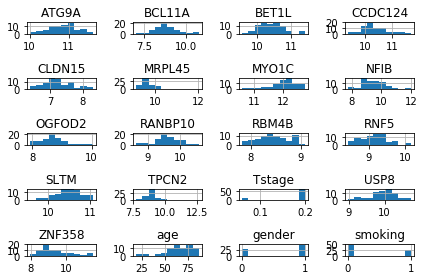

In [30]:
print('Distributions of the first 16 differentially expressed genes based on RNA-seq training data.')
print('-'*90)
rna_subset_16 = gene_subset(rna_X_train,pval_rna,16)
rna_subset_16 = rna_subset_16.astype(float)
rna_subset_16.hist();
plt.tight_layout()

Distributions of the first 16 differentially expressed genes based on microarray training data.
------------------------------------------------------------------------------------------


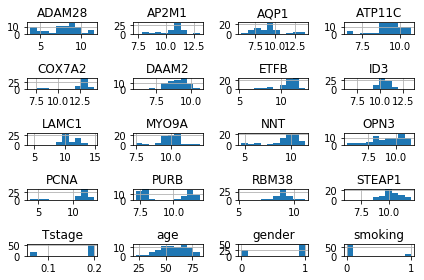

In [31]:
print('Distributions of the first 16 differentially expressed genes based on microarray training data.')
print('-'*90)
micro_subset_16 = gene_subset(micro_X_train,pval_micro,16)
micro_subset_16 = micro_subset_16.astype(float)
micro_subset_16.hist();
plt.tight_layout()

**6. Feature scaling**

From the distributions of some features, we could find that it seems like they all fall into the same magnitude which is good. However, some of algorithms may be sensitive to it for example Support Vector Machines. I tend to standardize features by removing the mean and scaling to unit variance.



In [32]:
def standprocess(train,test):
    stdSc = StandardScaler()
    train = stdSc.fit_transform(train)
    test = stdSc.transform(test)
    return train, test

In [33]:
rnas = rna_subset_16
micros = micro_subset_16
train_rna_16, train_micro_16 = standprocess(rnas,micros)

Distributions of the first 16 differentially expressed genes after scaling based on RNA-seq training data.
--------------------------------------------------------------------------------------------------------------


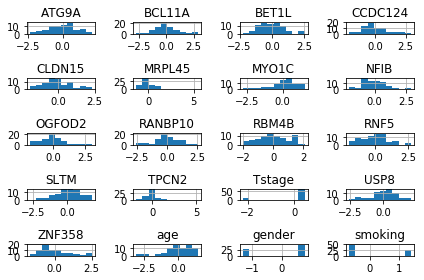

In [34]:
print('Distributions of the first 16 differentially expressed genes after scaling based on RNA-seq training data.')
print('-'*110)
train_rna_16 = pd.DataFrame(train_rna_16)
train_rna_16.columns =  list(rna_subset_16.columns)
train_rna_16.hist();
plt.tight_layout()

Distributions of the first 16 differentially expressed genes after scaling based on microarray training data.
--------------------------------------------------------------------------------------------------------------


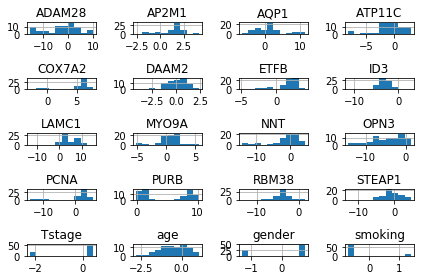

In [35]:
print('Distributions of the first 16 differentially expressed genes after scaling based on microarray training data.')
print('-'*110)
train_micro_16 = pd.DataFrame(train_micro_16)
train_micro_16.columns =  list(micro_subset_16.columns)
train_micro_16.hist();
plt.tight_layout()

### Short-List Promising Models

In [36]:
#Validation function
n_folds = 5
def rmsle_cv(model,x_train,y_train):
    kf = KFold(n_folds, shuffle=True, random_state=777).get_n_splits(x_train)
    auc_score= np.mean(cross_val_score(model, x_train, y_train, cv = kf,scoring='roc_auc'))
    return(auc_score)

In [37]:
DT = DecisionTreeClassifier(random_state=777)
svm = SVC(probability = True)
rf = RandomForestClassifier(random_state=777,class_weight='balanced')
knn = KNeighborsClassifier()
ada =  AdaBoostClassifier(random_state=777)
lr = LogisticRegression(random_state=777)

In [38]:
x_train_m = gene_subset(micro_X_train,pval_micro,250)
x_train_r = gene_subset(rna_X_train,pval_rna,250)

In [39]:
scorem = rmsle_cv(DT,x_train_m,micro_y_train)
print("\nDecision Tree Auc score on microarray dataset: {:.4f})".format(scorem.mean()))
scorer = rmsle_cv(DT,x_train_r,rna_y_train)
print("Decision Tree Auc score on RNA-seq dataset: {:.4f})".format(scorer.mean()))


Decision Tree Auc score on microarray dataset: 0.4875)
Decision Tree Auc score on RNA-seq dataset: 0.4067)


In [40]:
scorem = rmsle_cv(svm,x_train_m,micro_y_train)
print("\nSupport Vector Machine Auc score on microarray dataset: {:.4f}".format(scorem.mean()))
scorer = rmsle_cv(svm,x_train_r,rna_y_train)
print("Support Vector Machine Auc score on RNA-seq dataset: {:.4f}".format(scorer.mean()))


Support Vector Machine Auc score on microarray dataset: 0.3569
Support Vector Machine Auc score on RNA-seq dataset: 0.6082


In [41]:
scorem = rmsle_cv(rf,x_train_m,micro_y_train)
print("\nRandom Forest Auc score on microarray dataset: {:.4f}".format(scorem.mean()))
scorer = rmsle_cv(rf,x_train_r,rna_y_train)
print("Random Forest Auc score on RNA-seq dataset: {:.4f}".format(scorer.mean()))


Random Forest Auc score on microarray dataset: 0.3690
Random Forest Auc score on RNA-seq dataset: 0.4242


In [42]:
scorem = rmsle_cv(knn,x_train_m,micro_y_train)
print("\nk-nearest neighbors Auc score on microarray dataset: {:.4f}".format(scorem.mean()))
scorer = rmsle_cv(knn,x_train_r,rna_y_train)
print("k-nearest neighbors Auc score on RNA-seq dataset: {:.4f}".format(scorer.mean()))


k-nearest neighbors Auc score on microarray dataset: 0.4623
k-nearest neighbors Auc score on RNA-seq dataset: 0.5273


In [43]:
scorem = rmsle_cv(ada,x_train_m,micro_y_train)
print("\nAdaboost Auc score on microarray dataset: {:.4f}".format(scorem.mean()))
scorer = rmsle_cv(ada,x_train_r,rna_y_train)
print("Adaboost Auc score on RNA-seq dataset: {:.4f}".format(scorer.mean()))


Adaboost Auc score on microarray dataset: 0.4139
Adaboost Auc score on RNA-seq dataset: 0.4373


In [44]:
scorem = rmsle_cv(lr,x_train_m, micro_y_train)
print("\nLogistic Regression Auc score on microarray dataset: {:.4f}".format(scorem.mean()))
scorer = rmsle_cv(lr,x_train_r, rna_y_train)
print("Logistic Regression Auc score on RNA-seq dataset: {:.4f}".format(scorer.mean()))


Logistic Regression Auc score on microarray dataset: 0.4731
Logistic Regression Auc score on RNA-seq dataset: 0.5512


We try many quick and dirty models from different categories using standard parameters. After measuring and comparing their performance, we plan to pick Random Forest, Logistic Regression and KNN alogrithms because they are fitting well now and seem like promising models after fine tuning the hyperparameters. Since the number of data instances is relatively small, we do not need to consider running time and space. I will use **GridSearchCV** function to tweak parameters.

### Fine-Tune the System

In this part, we will use grid search cross-validation method to tweak the hyper-parameters for different models based on two different datasets and pick the best model with the best subset of genes to make prediction on the test set. Then plot the ROC curve and return the specificity on the test dataset that can be achieved while maintaining 80% sensitivity for each case.

In [45]:
def Gridsearchcv(x_train,y_train,model,param,cv_num):
    # random search + cross validation
    gridsearch = GridSearchCV(model,param,cv = cv_num,scoring='roc_auc',n_jobs = 7)
    # train model in train set
    gridsearch.fit(x_train,y_train)
    # return search results for each case
    result = gridsearch.cv_results_
    for mean_score, params in zip(result["mean_test_score"], result["params"]):
        print(np.mean(mean_score), params)
    # get the best estimator
    best_model = gridsearch.best_estimator_
    print('Best model:\n')
    print(best_model)
    print('\n Optimal parameters:')
    print(gridsearch.best_params_)
    best_model.fit(x_train,y_train)
    return best_model

In [46]:
def ROC_curve(x_train,y_train,x_test,y_test,model):
    fprs = []
    tprs = []
    threshold = []
    # use model fit training data
    model.fit(x_train,y_train)
    y_train_pred = model.predict_proba(x_train)
    # compute tpr, fpr to plot ROC curve for training set
    fpr_train, tpr_train, thresholds = roc_curve(y_train, y_train_pred[:,1])
    roc_auc_train = auc(fpr_train, tpr_train)
    # use model predict test data
    y_pred = model.predict_proba(x_test)
    y_preds = model.predict(x_test)
    # compute tpr, fpr to plot ROC curve for test set
    fpr_test, tpr_test, thresholds = roc_curve(y_test, y_pred[:,1])
    fprs.append(fpr_test)
    tprs.append(tpr_test)
    threshold.append(thresholds)
    roc_auc_test = auc(fpr_test, tpr_test)
    # Plot ROC curve and compare them
    plt.plot(fpr_train, tpr_train,  linewidth=2, label='Train AUC = %0.2f'% roc_auc_train);
    plt.plot(fpr_test, tpr_test, linewidth=2, label='Test AUC = %0.2f'% roc_auc_test)
    plt.title("Receiving Operating Characteristic")
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    return tprs, fprs, threshold

**1. Random Forest**

- Tuning parameters based on microarray datset with the first 80 differentially expressed genes.

In [47]:
## Microarray dataset 
train_m = gene_subset(micro_X_train,pval_micro,80)
test_m = gene_subset(micro_X_test,pval_micro,80)
train_M, test_M = standprocess(train_m, test_m)

In [48]:
rf = RandomForestClassifier(random_state=11,class_weight={0:0.46,1:0.54})
print('Grid search results based on microarray dataset:\n')
param = {'n_estimators':[200,300],
               'max_depth':[10,20],
               'min_samples_leaf':[5,7],
               'min_samples_split':[2,5],
        'class_weight':[{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45, 1:0.55}]}
best_rf = Gridsearchcv(train_m,micro_y_train,rf,param,3)

Grid search results based on microarray dataset:

0.294194390084801 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
0.30156555772994126 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
0.294194390084801 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
0.30156555772994126 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}
0.29217221135029353 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 200}
0.3060665362035225 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 300}
0.29217221135029353 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split':

- Evaluation on the test set

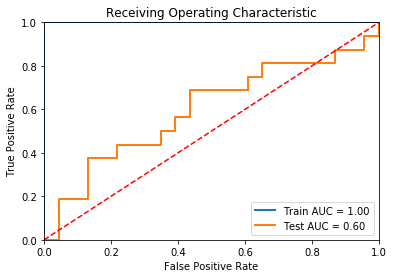

Sensitivity: 0.8125
Specificity: 0.34782608695652173


In [49]:
# plot roc curve
x_train = train_m; y_train = micro_y_train; x_test = test_m; y_test = micro_y_test; model = best_rf
tpr, fpr, threshold = ROC_curve(x_train,y_train,x_test,y_test,model)
print('Sensitivity:',tpr[0][tpr[0]>=0.8][0])
print('Specificity:',1-fpr[0][np.where(tpr[0] >= 0.8)[0][0]])

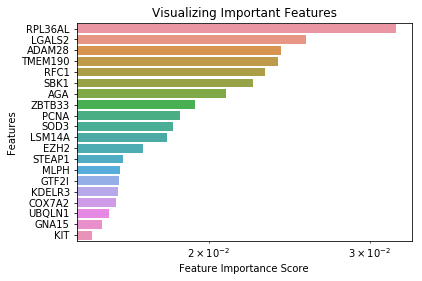

In [50]:
# Visualize feature importance
feature_imp = pd.Series(best_rf.feature_importances_,
       index=train_m.columns).sort_values(ascending=False)
a=sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
a.set_xscale('log')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [51]:
print('Feature rank:')
genes = []
for score, feature in sorted(zip(best_rf.feature_importances_, train_m.columns), reverse=True)[:20]:
    if score >0.01:
        genes.append(feature)
        print('{0:26} {1:3}'.format(feature,score))

Feature rank:
RPL36AL                    0.03205068679327539
LGALS2                     0.025546597570576698
ADAM28                     0.02397507744668221
TMEM190                    0.0238240829056796
RFC1                       0.023028718155894013
SBK1                       0.02234390524266666
AGA                        0.02089568083592667
ZBTB33                     0.019338157330642734
PCNA                       0.018597584780518175
SOD3                       0.018285212310416077
LSM14A                     0.01802436745564906
EZH2                       0.016944024164921922
STEAP1                     0.01611326159247419
MLPH                       0.016008944031486876
GTF2I                      0.015970319230009602
KDELR3                     0.015930141724091667
COX7A2                     0.015840693037015473
UBQLN1                     0.015558833413339392
GNA15                      0.015289406461378231
KIT                        0.014920296748860121


- Tuning parameters based on RNA-seq datset with the first 450 differentially expressed genes.

In [52]:
## RNA-seq dataset #450
train_r = gene_subset(rna_X_train,pval_rna,450)
test_r = gene_subset(rna_X_test,pval_rna,450)
train_R, test_R = standprocess(train_r, test_r)

In [53]:
rf = RandomForestClassifier(random_state=7,class_weight={0:0.46,1:0.54})
print('Grid search results based on microarray dataset:\n')
param = {'n_estimators':[200,300],
               'max_depth':[10,20],
               'min_samples_leaf':[5,7],
               'min_samples_split':[2,5],
        'class_weight':[{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45, 1:0.55}]}
best_rf = Gridsearchcv(train_r,rna_y_train,rf,param,3)

Grid search results based on microarray dataset:

0.4594034797017397 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
0.48122065727699537 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
0.4594034797017397 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
0.48122065727699537 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}
0.4215225996501888 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 200}
0.4246524901040229 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 300}
0.4215225996501888 {'class_weight': {0: 0.4, 1: 0.6}, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split':

- Evaluation on the test set

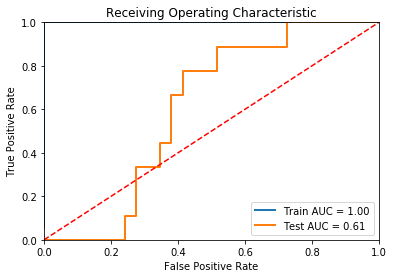

Sensitivity: 0.8888888888888888
Specificity: 0.48275862068965514


In [54]:
# plot roc curve
x_train = train_r; y_train = rna_y_train; x_test = test_r; y_test = rna_y_test; model = best_rf
tpr, fpr, threshold = ROC_curve(x_train,y_train,x_test,y_test,model)
print('Sensitivity:',tpr[0][tpr[0]>=0.8][0])
print('Specificity:',1-fpr[0][np.where(tpr[0] >= 0.8)[0][0]])

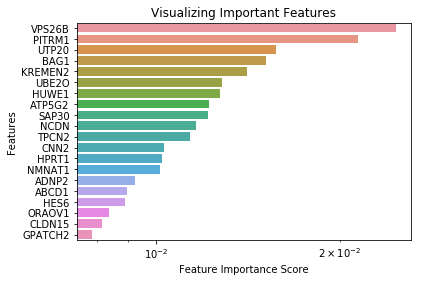

In [55]:
# Visualize feature importance
feature_imp = pd.Series(best_rf.feature_importances_,
       index=train_r.columns).sort_values(ascending=False)
a=sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
a.set_xscale('log')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [56]:
print('Feature rank:')
genes = []
for score, feature in sorted(zip(best_rf.feature_importances_, train_r.columns), reverse=True)[:20]:
    if score >0.01:
        genes.append(feature)
        print('{0:26} {1:3}'.format(feature,score))

Feature rank:
VPS26B                     0.02475031087033508
PITRM1                     0.02141396772982476
UTP20                      0.015729504289485375
BAG1                       0.015168473896298952
KREMEN2                    0.01410192690527457
UBE2O                      0.012844039558373061
HUWE1                      0.012732096337099989
ATP5G2                     0.012220440212460477
SAP30                      0.012192891225620268
NCDN                       0.011627711638561198
TPCN2                      0.011392012524951286
CNN2                       0.010321949036348891
HPRT1                      0.010220748667912
NMNAT1                     0.010173553236606469


**2. Logistic Regression**

- Based on RNA-seq datset with the first 510 differentially expressed genes.

In [57]:
## RNA-seq dataset 
train_r = gene_subset(rna_X_train,pval_rna,510)
test_r = gene_subset(rna_X_test,pval_rna,510)
## standardize the dataset
train_R, test_R = standprocess(train_r,test_r)

In [58]:
lr  = LogisticRegression(random_state=111,class_weight='balanced')
print('Grid search results based on microarray dataset:\n')
param = {'C':[1,10,20],'penalty':['l1','l2']}
best_lr = Gridsearchcv(train_R,rna_y_train,lr,param,5)

Grid search results based on microarray dataset:

0.5353179684165599 {'C': 1, 'penalty': 'l1'}
0.5122065727699531 {'C': 1, 'penalty': 'l2'}
0.5043107127614169 {'C': 10, 'penalty': 'l1'}
0.5449210413999146 {'C': 10, 'penalty': 'l2'}
0.5056124626547163 {'C': 20, 'penalty': 'l1'}
0.5449210413999146 {'C': 20, 'penalty': 'l2'}
Best model:

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=111,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Optimal parameters:
{'C': 10, 'penalty': 'l2'}


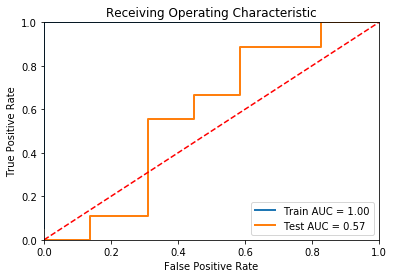

Sensitivity: 0.8888888888888888
Specificity: 0.4137931034482759


In [59]:
x_train = train_R; y_train = rna_y_train; x_test = test_R; y_test = rna_y_test; model = best_lr
tpr, fpr, threshold = ROC_curve(x_train,y_train,x_test,y_test,model)
print('Sensitivity:',tpr[0][tpr[0]>=0.8][0])
print('Specificity:',1-fpr[0][np.where(tpr[0] >= 0.8)[0][0]])

- Based on microarray datset with the first 200 differentially expressed genes.

In [60]:
## Microarray dataset 
train_m = gene_subset(micro_X_train,pval_micro,200)
test_m = gene_subset(micro_X_test,pval_micro,200)
## standardize the dataset
train_M, test_M = standprocess(train_m,test_m)

In [61]:
lr  = LogisticRegression(random_state=77,class_weight='balanced')
print('Grid search results based on microarray dataset:\n')
param = {'C':[1,10,15,20],'penalty':['l1','l2']}
best_lr = Gridsearchcv(train_M,micro_y_train,lr,param,5)

Grid search results based on microarray dataset:

0.508751902587519 {'C': 1, 'penalty': 'l1'}
0.48211567732115673 {'C': 1, 'penalty': 'l2'}
0.4823059360730594 {'C': 10, 'penalty': 'l1'}
0.48649162861491635 {'C': 10, 'penalty': 'l2'}
0.4939117199391172 {'C': 15, 'penalty': 'l1'}
0.49410197869101974 {'C': 15, 'penalty': 'l2'}
0.5133181126331812 {'C': 20, 'penalty': 'l1'}
0.49809741248097417 {'C': 20, 'penalty': 'l2'}
Best model:

LogisticRegression(C=20, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=77,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Optimal parameters:
{'C': 20, 'penalty': 'l1'}


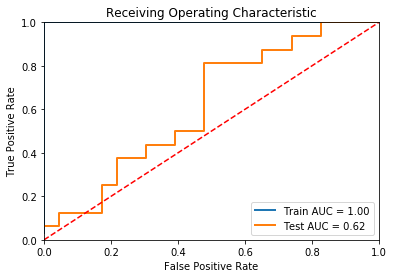

Sensitivity: 0.8125
Specificity: 0.5217391304347826


In [62]:
x_train = train_M; y_train = micro_y_train; x_test = test_M; y_test = micro_y_test; model = best_lr
tpr, fpr, threshold = ROC_curve(x_train,y_train,x_test,y_test,model)
print('Sensitivity:',tpr[0][tpr[0]>=0.8][0])
print('Specificity:',1-fpr[0][np.where(tpr[0] >= 0.8)[0][0]])

**3. k-nearest neighbors**

- Based on RNA-seq datset with the first 40 differentially expressed genes.

In [63]:
## RNA-seq dataset 
train_r = gene_subset(rna_X_train,pval_rna,40)
test_r = gene_subset(rna_X_test,pval_rna,40)
## standardize the dataset
train_R, test_R = standprocess(train_r,test_r)

In [64]:
knn  = KNeighborsClassifier()
print('Grid search results based on microarray dataset:\n')
param = {'n_neighbors':[6,7,8,9,10],'weights':['uniform','distance'],
        'p':[1,2,3]}
random.seed(7)
best_knn = Gridsearchcv(train_R,rna_y_train,knn,param,5)

Grid search results based on microarray dataset:

0.43607554417413574 {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
0.44848484848484843 {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
0.5187580025608194 {'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}
0.5652262057191634 {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
0.5218096457533077 {'n_neighbors': 6, 'p': 3, 'weights': 'uniform'}
0.5988369611609047 {'n_neighbors': 6, 'p': 3, 'weights': 'distance'}
0.4997972684592403 {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.5074050362782757 {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.5931818181818181 {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.5698250106700811 {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
0.5340588988476312 {'n_neighbors': 7, 'p': 3, 'weights': 'uniform'}
0.5842296201451129 {'n_neighbors': 7, 'p': 3, 'weights': 'distance'}
0.4840909090909091 {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
0.4794921041399915 {'n_neighbors': 8, 'p': 1, 'weights': '

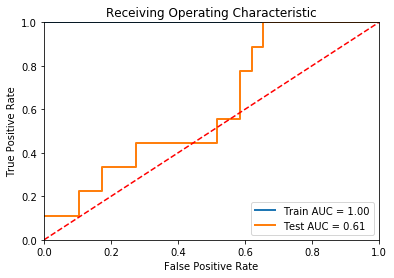

Sensitivity: 0.8888888888888888
Specificity: 0.3793103448275862


In [65]:
x_train = train_R; y_train = rna_y_train; x_test = test_R; y_test = rna_y_test; model = best_knn
tpr, fpr, threshold = ROC_curve(x_train,y_train,x_test,y_test,model)
print('Sensitivity:',tpr[0][tpr[0]>=0.8][0])
print('Specificity:',1-fpr[0][np.where(tpr[0] >= 0.8)[0][0]])

- Based on microarray datset with the first 40 differentially expressed genes.


In [66]:
## Microarray dataset 
train_m = gene_subset(micro_X_train,pval_micro,40)
test_m = gene_subset(micro_X_test,pval_micro,40)
## standardize the dataset
train_M, test_M = standprocess(train_m,test_m)

In [67]:
knn  = KNeighborsClassifier()
random.seed(77)
print('Grid search results based on microarray dataset:\n')
param = {'n_neighbors':[6,7,8,9],'weights':['uniform','distance'],
        'p':[1,2,3,4]}
best_knn = Gridsearchcv(train_M,micro_y_train,knn,param,5)

Grid search results based on microarray dataset:

0.5059931506849316 {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
0.44843987823439874 {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
0.5106544901065448 {'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}
0.42560882800608824 {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
0.4870624048706241 {'n_neighbors': 6, 'p': 3, 'weights': 'uniform'}
0.41210045662100453 {'n_neighbors': 6, 'p': 3, 'weights': 'distance'}
0.43103120243531207 {'n_neighbors': 6, 'p': 4, 'weights': 'uniform'}
0.377283105022831 {'n_neighbors': 6, 'p': 4, 'weights': 'distance'}
0.5354832572298326 {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.48744292237442927 {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.47612252663622523 {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.4244672754946728 {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
0.5470890410958904 {'n_neighbors': 7, 'p': 3, 'weights': 'uniform'}
0.46765601217656005 {'n_neighbors': 7, 'p': 3, 'weights

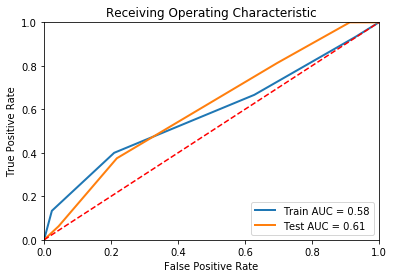

Sensitivity: 0.8125
Specificity: 0.30434782608695654


In [68]:
x_train = train_M; y_train = micro_y_train; x_test = test_M; y_test = micro_y_test; model = best_knn
tpr, fpr, threshold = ROC_curve(x_train,y_train,x_test,y_test,model)
print('Sensitivity:',tpr[0][tpr[0]>=0.8][0])
print('Specificity:',1-fpr[0][np.where(tpr[0] >= 0.8)[0][0]])

### Present the Solution

In our project, random forest, k-Nearest Neighbors, and logistic regression are utilized to establish a classifier.
In order to obtain comparable results, we try all three methods on RNA sequence dataset and microarrays dataset. First, we process the target variable "NodeStatus", which equals to 1 corresponding to "positive" and 0 corresponding to "negative". Second, we pick some relevant features 'age', 'smoking', and 'gender' from the phenotype dataset, convert and combine them with gene expressions dataset. Then we split both datasets randomly into the training set and test set. Training set will be further split into validation set which helps us pick parameters and train set which is utilized to train models. We will not touch test set until the last moment comes when all models are set up and tuned well. Additionally, detecting differentially expressed genes is very important for building our classifier. There are various methods to identify DEGs and here we use a non-parametric one Wilcoxon rank sum test because the amount of our dataset is relatively too small. We create functions to process, split datasets and standardize features which are prerequisite for some of machine learning algorithms. After preparing the data, we try several categories methods, compare their performance and pick some of the promising ones and use GridSearch cross-validation method to extensively tune hyper-parameters. Evaluate the results on RNA sequence dataset and microarray dataset with a different number of differentially expressed genes by plotting ROC curve and reporting Sensitivity and Specificity, respectively. For each ROC curve, we find the point which sens($t_{80}$) ≥ 0.80 and report the corresponding specificity spec($t_{80}$).

- Comparison of results



   
| Dataset   |  |Random Forest                       |  Logistic Regression  | K-Nearest Neighbors | 
| :------   | :--------------------------------:    |
| RNA-seq   | [Sensitivity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) | 0.8889(450DEGs)|0.8889(510DEGs)|0.8889(40DEGs)|
|           | [Specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) | 0.4828(450DEGs)|0.4138(510DEGs)|0.3793(40DEGs)|
|Microarray | [Sensitivity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) | 0.8125(80DEGs) |0.8125(200DEGs)|0.8125(40DEGs)|
|           | [Specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) | 0.3478(80DEGs) |0.5217(200DEGs)|0.3043(40DEGs)|
> DEGs is short for differentially expressed genes.


- Describe what worked, what did not and what can try in the future.
 1. Standardizing differentially expressed genes and adjusting the number of DEGs in the training and test set help us improve the AUC score.
 2. Since the number of features is much larger than the amount of dataset, for different classification algorithms, the performance will be significantly influenced by selected features. The optimal number of genes to be selected is variant and can be considered as a hyper-parameter.
 3. Directly combining RNA-seq with microarray dataset together to fit the model does not improve classification performance. 
 4. Domain knowledge is a requirement for merging two datasets collected by different technology, but if it works, it will greatly improve the accuracy of our classification.
 5. Other detecting methods of DEGs may work, except for some statistical methods, it is a good idea to use feature importance of tree models, combining them with genes selected by Wilcoxon rank sum test to train a model.


- Reference<br>
[Microarray Data Analysis](https://discover.nci.nih.gov/microarrayAnalysis/Statistical.Tests.jsp)<br>
[Integrating gene expression profiles across different platforms](https://www.rna-seqblog.com/integrating-gene-expression-profiles-across-different-platforms/)<br>
[An Improved Method on Wilcoxon Rank Sum Test for Gene Selection from Microarray Experiments](https://www.tandfonline.com/doi/abs/10.1080/03610918.2012.667479)